## Poisson方程

$$
\begin{cases}
Lu = -u''(x) = f(x) \quad x \in G, \\
u(0)=u(\pi)=0
\end{cases}
$$

其中f(x) = sin(x), G = [0, $\pi$], 真解为u(x) = sin(x)。

In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from fealpy.mesh import IntervalMesh
from fealpy.decorator import cartesian
from fealpy.quadrature import IntervalQuadrature
import matplotlib.pyplot as plt

class pde():
    def __init__(self):
        pass
    
    def domain(self):
        return [0, np.pi]
    
    @cartesian
    def solution(self,x):
        return np.sin(x)
    
    @cartesian
    def gradient(self,p):
        x = p[...,0] # 返回p中最后一个指标为0的数组
        return np.cos(x)
    
    @cartesian
    def source(self,p):
        x = p[...,0]
        return np.sin(x)

pde = pde()
    
#剖分次数
n = [1,2,3,4,5]
e = np.zeros(len(n), dtype=np.float64)
h = np.zeros(len(n), dtype=np.float64)
for i in range(len(n)):

    node = np.array([
        [0.0],
        [np.pi]
    ])
    cell = np.array([
        [0,1]
    ])
    mesh = IntervalMesh(node, cell)
    mesh.uniform_refine(n = n[i])

    #剖分点的x值
    node = mesh.entity('node')
    #剖分区间两端点的编号(即node中的下标)
    cell = mesh.entity('cell')

    NC = mesh.number_of_cells()
    NN = mesh.number_of_nodes()
    cm = mesh.entity_measure('cell') #(NC,), 每个单元的长度

    #(NC,2,1), 为每个区间上N_0(\varepilon),N_1(\varepsilon)对x的导数
    glambda = mesh.grad_lambda() 
    #print("glambda=", glambda)
    #print("cm=", cm)

    S = np.einsum('cim, cjm, c->cij', glambda, glambda, cm) #[NC,2,2]
    #print("S=", S)

    #cell[:,:,None] 增加一列
    #broadcast_to 将cell缺少的列复制几遍
    I = np.broadcast_to(cell[:, :, None], shape=S.shape) #[NC,2]-->[NC,2,1]-->[NC,2,2]
    J = np.broadcast_to(cell[:, None, :], shape=S.shape) #[NC,2]-->[NC,1,2]-->[NC,2,2]

    #S[c,i,j]将会放在 S[I[c,i,j], J[c,i,j]] 上, 并转换为稀疏矩阵
    S = csr_matrix((S.flat, (I.flat, J.flat)), shape=(NN,NN))

    #每个区间上的积分点数
    NQ = 4
    qf = IntervalQuadrature(NQ)

    #bcs [NQ,2], 每个积分区间上的\lambda_0,\lambda_1(和为1); ws [NQ,], 积分区间上各点的权值
    bcs,ws = qf.get_quadrature_points_and_weights() 
    phi = bcs

    A = S

    # ps [NQ,NC,1]，所有积分点的x值
    #node[cell].shape == [NC,2,1]，每个区间的端点值
    ps = np.einsum('qi, cim->qcm', bcs, node[cell]) 

    #[NQ,NC], 所有积分点的右端函数值
    val = pde.source(ps) 
    #[NC,2], 每个区间上\phi_{i-1}、\phi_i 与 f 的内积
    bb = np.einsum('q,qc,qi,c->ci', ws, val, bcs, cm) 

    F = np.zeros(NN)
    #将 bb 按各区间两端点编号求和
    np.add.at(F,cell,bb)

    isBdNode = mesh.ds.boundary_node_flag() #[NN,]

    isInterNode = ~isBdNode

    uh = np.zeros(NN, dtype=np.float64)
    #有边界条件知uh[0]=uh[n]=0
    uh[isInterNode] = spsolve(A[:, isInterNode][isInterNode], F[isInterNode]) 

    #print("node=", node.shape)
    #print("cell=", cell)
    #print("isInterNode=", isInterNode)

    uI = pde.solution(node)
    ns = uI.shape
    uI = uI.reshape(ns[0])
    h[i] = cm[0]
    e_tmp = uh-uI
    e[i] = np.sqrt(e_tmp@e_tmp) 
print("h= ", h)
print("e= ", e)

h=  [1.57079633 0.78539816 0.39269908 0.19634954 0.09817477]
e=  [1.63818602e-07 8.29243097e-10 4.48403536e-12 2.11852959e-14
 1.33128706e-14]


 
6.236 x - 19.39


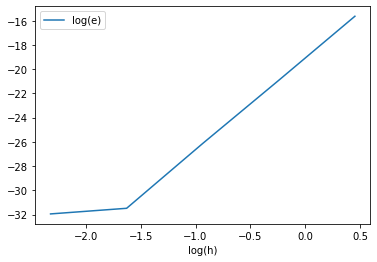

In [4]:
f = np.polyfit(np.log(h), np.log(e), 1)
p = np.poly1d(f)
print(p)

plt.plot(np.log(h), np.log(e), label="log(e)")
plt.xlabel("log(h)")
plt.legend()

/home/chisa/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chisa/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chisa/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chisa/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


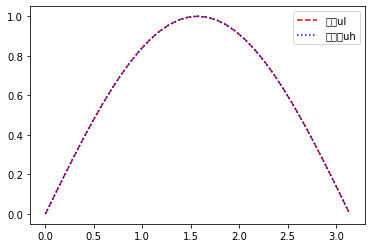

In [5]:
def my_sort(A):
    n = A.shape[1]
    for i in range(n-1):
        for j in range(i+1,n):
            if(A[0][i] > A[0][j]):
                for k in range(3):
                    tmp = A[k][i]
                    A[k][i] = A[k][j]
                    A[k][j] = tmp

A = np.zeros((3,NN), dtype=np.float64)
A[0] = node.reshape(NN)
A[1] = uI
A[2] = uh

my_sort(A)

plt.plot(A[0],A[1],linestyle='--',color='r',label='真解uI')
plt.plot(A[0],A[2],linestyle=':',color='b',label='数值解uh')
plt.legend()

In [154]:
import numpy as np

a = np.array([[1,2], [3,4]])
print("a= ", a)
print("a.shape= ", a.shape)
print("a[:,None]=", a[:,:,None])
print("a[:,None].shape=", a[:,:,None].shape)
print("")
print ("a[Nome,:]=", a[:,None,:])
print ("a[Nome,:].shape=", a[:,None,:].shape)
 
b = np.broadcast_to(a[:,:,None], shape=[2,2,2])
print("b=", b)

c = np.broadcast_to(a[:,None,:], shape=[2,2,2])
print("c=", c)

a=  [[1 2]
 [3 4]]
a.shape=  (2, 2)
a[:,None]= [[[1]
  [2]]

 [[3]
  [4]]]
a[:,None].shape= (2, 2, 1)

a[Nome,:]= [[[1 2]]

 [[3 4]]]
a[Nome,:].shape= (2, 1, 2)
b= [[[1 1]
  [2 2]]

 [[3 3]
  [4 4]]]
c= [[[1 2]
  [1 2]]

 [[3 4]
  [3 4]]]
